In [224]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pmdarima as pm
import os
import seaborn as sns
import skforecast


from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.recursive import ForecasterRecursive
# TODO: Check which of the following get used once notebook is finalized,
# gid rid of rest
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster, TimeSeriesFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA

In [225]:
# Saving url for Git repository
git_url = 'https://github.com/tarachiatovich/zero_to_ai_sdp_2025/'
# Reading in data from Git
# Datasource (open, publicly available):
# https://opendata.cityofnewyork.us/
# I took several separate data files, each with a
# few years and concatenated and cleaned them a bit
# Then I randomly sampled 15 schools (out of thousands
# originally!) to keep the data small
# You can see the original data in raw_data/attendance
# folder on Git
# TODO: Will need to update once branch in merged
git_nyc_path = git_url +\
    'blob/improve_tabular_notebooks/clean_data/attendance/full_attendance_data.csv?raw=true'

In [226]:
attendance_data = pd.read_csv(git_nyc_path)

In [227]:
# Look at the columns
attendance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26766 entries, 0 to 26765
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   School      26766 non-null  object 
 1   Date        26766 non-null  object 
 2   SchoolYear  26766 non-null  int64  
 3   Enrolled    26762 non-null  float64
 4   Absent      26762 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.0+ MB


In [228]:
# Let's look at a frequency table for School values
attendance_data['School'].value_counts()

School
07X223    2086
03M149    2083
01M015    2083
27Q060    2083
10X080    2083
09X229    2083
06M322    2081
02M630    1947
12X479    1947
02M418    1942
02M420    1942
02M267    1902
05M514    1721
04M310     618
18K500     165
Name: count, dtype: int64

In [229]:
# We need the Date column to be an official
# datetime object
attendance_data['Date'] = pd.to_datetime(
    attendance_data['Date'], dayfirst=False, format='mixed'
)

In [230]:
# We're going to work with just one school for now,
# though you can do the same analysis choosing another
# school later on
school_id_to_use = '01M015'

In [231]:
# Creating dataframes limited to one school
data_1_school = attendance_data.loc[attendance_data['School'] == school_id_to_use].sort_values('Date')

In [232]:
data_1_school.Date.value_counts()

Date
2021-06-25    1
2009-09-09    1
2009-09-10    1
2021-06-01    1
2021-05-28    1
             ..
2009-09-18    1
2009-09-17    1
2009-09-16    1
2009-09-15    1
2009-09-14    1
Name: count, Length: 2083, dtype: int64

<Axes: xlabel='Date', ylabel='Count'>

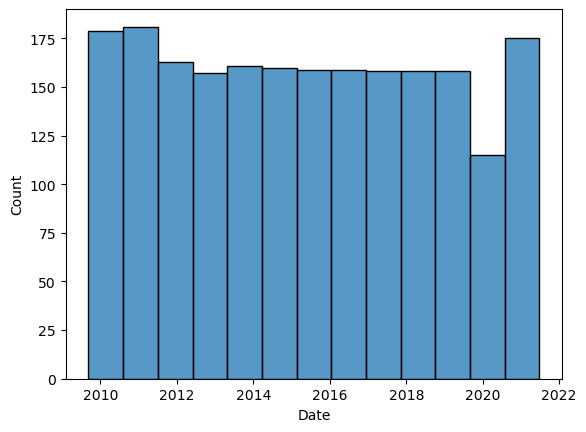

In [233]:
# Look at histogram giving dates for first school
# These bars look nice and even, except for circa
# 2020, which is no surprise given the pandemic
sns.histplot(data=data_1_school, x='Date')

<Axes: xlabel='Date', ylabel='Absent'>

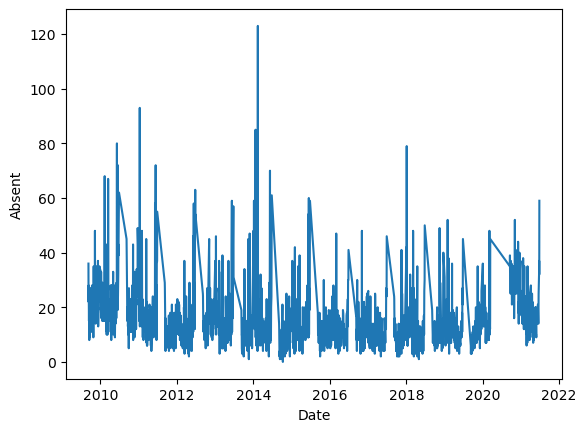

In [234]:
# What does the count of absences look like across time for first school?
sns.lineplot(data=data_1_school, x='Date', y='Absent')

In [235]:
# Create an absence rate that adjusts for enrollment for both schools
data_1_school['AbsenceRate'] = data_1_school['Absent']/data_1_school['Enrolled']

In [236]:
# Let's get descriptives on AbsenceRate
data_1_school[['AbsenceRate', 'Absent']].describe()

,AbsenceRate,Absent
count,2083.000000,2083.000000
mean,0.081130,15.245319
std,0.054027,10.506703
min,0.000000,0.000000
25%,0.047120,9.000000
50%,0.068421,13.000000
75%,0.097826,18.500000
max,0.618090,123.000000


In [237]:
# Look at first few rows of data with AbsenceRate
data_1_school.head()

,School,Date,SchoolYear,Enrolled,Absent,AbsenceRate
0,01M015,2009-09-09,20092010,210.0,36.0,0.171429
1,01M015,2009-09-10,20092010,215.0,22.0,0.102326
2,01M015,2009-09-11,20092010,213.0,28.0,0.131455
3,01M015,2009-09-14,20092010,214.0,15.0,0.070093
4,01M015,2009-09-15,20092010,214.0,20.0,0.093458


<Axes: xlabel='Date', ylabel='AbsenceRate'>

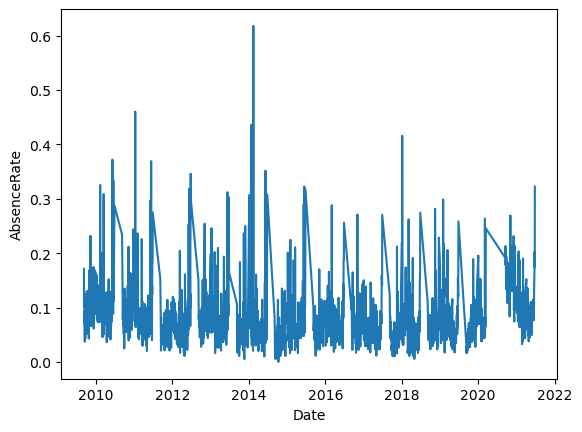

In [238]:
# Let's look at absence rate for second school
sns.lineplot(data=data_1_school, x='Date', y='AbsenceRate')
# Looks very similar to the plot for second school for Absent
# So enrollment may not be shifting enough for the AbsenceRate
# to pick up something different than Absence. Still, it's a metric
# we can more easily interpret (e.g., > 60% of enrolled students were
# absent at the beginning of 2014), so let's use AbsenceRate for
# our models

In [239]:
# Let's get the data ready for analyses
tscv = TimeSeriesSplit(n_splits=2, test_size=180)
data_1_school_for_ts = data_1_school.copy()

In [240]:
data_1_school_for_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083 entries, 0 to 24490
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   School       2083 non-null   object        
 1   Date         2083 non-null   datetime64[ns]
 2   SchoolYear   2083 non-null   int64         
 3   Enrolled     2083 non-null   float64       
 4   Absent       2083 non-null   float64       
 5   AbsenceRate  2083 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 113.9+ KB


In [241]:
# Look at the first few rows of data
data_1_school_for_ts.head()

,School,Date,SchoolYear,Enrolled,Absent,AbsenceRate
0,01M015,2009-09-09,20092010,210.0,36.0,0.171429
1,01M015,2009-09-10,20092010,215.0,22.0,0.102326
2,01M015,2009-09-11,20092010,213.0,28.0,0.131455
3,01M015,2009-09-14,20092010,214.0,15.0,0.070093
4,01M015,2009-09-15,20092010,214.0,20.0,0.093458


In [245]:
# Getting together the "split" data
# TimeSeriesSplit includes 1723:1902 as the test data in the first fold
# and 109:2082 as the test data in the second fold
# Therefore we can use data from the first fold to get our model up and running
# and then once we are happy with our model for that dataframe, do a final check
# of how it runs on  the dataframe from the second fold (keeping in mind that the
# second fold will include data from fall 2020 --> a challenging "test" of our model!
train_test_indices = {}
for i, (train_index, test_index) in enumerate(tscv.split(data_1_school_for_ts['Date'])):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train_test_indices[f"train_fold_{i}"] = train_index
    train_test_indices[f"test_fold_{i}"] = test_index

Fold 0:
  Train: index=[   0    1    2 ... 1720 1721 1722]
  Test:  index=[1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736
 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750
 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764
 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778
 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792
 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806
 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820
 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834
 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848
 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862
 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876
 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890
 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902]
Fold 1:
  Tr

In [246]:
# This part is very "Python-y" and may be confusing for people who are new to Python
# The TrainTestSplit that we ran above created two dataframes, each with two different
# splits of the data
# My loop named the first dataframe train_test_indices['train_fold_0'], and the [0]
# I added at the end tells Python we only want the first "split" (the training data)
# Similarly, we can use train_test_indices['train_fold_0'][-1] to get the last (of 2)
# splits. If you've used indices in R (e.g., `df[3,]` to get just the third row of an
# R dataset named df), the idea is similar here. But what is different is that indices
# in Python start with 0, and if you are unsure or don't know what the last index is,
# you can use the index -1, which will give you the last (and -2 will give you the second
# to last, etc.)
train_start = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][0]]['Date']
train_end = data_1_school_for_ts.iloc[train_test_indices['train_fold_0'][-1]]['Date']

test_start = data_1_school_for_ts.iloc[train_test_indices['test_fold_0'][0]]['Date']
test_end = data_1_school_for_ts.iloc[train_test_indices["test_fold_0"][-1]]['Date']

In [247]:
# Let's check on the start and end dates
print(train_start)
print(train_end)
print(test_start)
print(test_end)

2009-09-09 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2020-03-06 00:00:00


In [248]:
data_1_school_for_ts.set_index('Date', inplace = True)

In [249]:
data_1_school_for_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2083 entries, 2009-09-09 to 2021-06-25
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   School       2083 non-null   object 
 1   SchoolYear   2083 non-null   int64  
 2   Enrolled     2083 non-null   float64
 3   Absent       2083 non-null   float64
 4   AbsenceRate  2083 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 97.6+ KB


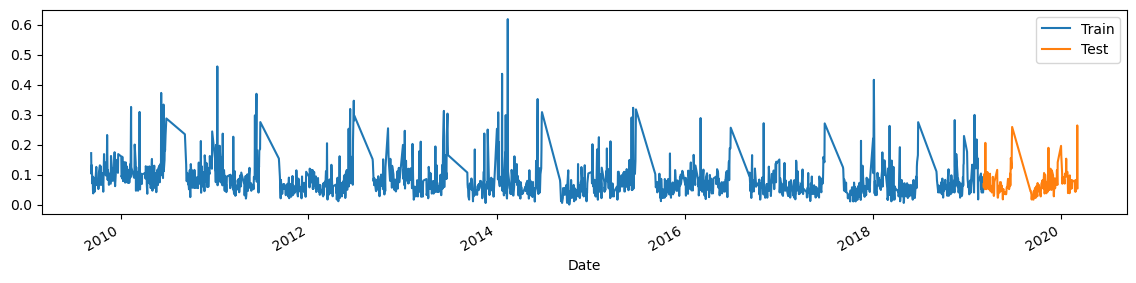

In [250]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_1_school_for_ts['AbsenceRate'].loc[test_start: test_end].plot(ax=ax, label = "Test")
ax.legend()

In [252]:
# TODO: Fix warning; warning about indices may also help with using TimeSeriesFold in skforecaster
# I consulted this source: https://medium.com/@mouse3mic3/a-practical-guide-on-scikit-learn-for-time-series-forecasting-bbd15b611a5d
# But there were issues with this one initially (see legacy code for ForecasterRecursive and LGBMRegressor, not sure of source)
# And the above source does not appear to give all needed import statements

# Set the values for the index for the predictions, based
# on start and end dates for test that are actually in the
# data
dates_for_preds = data_1_school_for_ts.loc[test_start: test_end].index.values
# Define the forecaster
forecaster_tree=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=DecisionTreeRegressor(random_state=123),
    lags=20
)
# Define the forecaster
forecaster_lgbmr=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=LGBMRegressor(random_state=123, verbose=-1),
    lags=20
)

# Store the model algorithms in a list for looping
model_algs = [forecaster_tree, forecaster_lgbmr]
# Store a name for each model algorithm, also for looping
model_names = ['tree', 'lgbmr']
# Create an empty map for storing the data, the root mean square error
reg_model_preds = {}
reg_model_rmses = {}
# Fit the models using train data
for model_alg, model_name in zip(model_algs, model_names):
    # 
    model_alg.fit(y = data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

    # Predict the test period
    predicted_test = model_alg.predict(steps = len(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end]))
    predicted_test = pd.DataFrame(predicted_test)
    predicted_test['Date'] = dates_for_preds
    predicted_test.set_index('Date', inplace = True)

    # Get RMSE
    rmse_test = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end], predicted_test))
    print(f'RMSE for {model_name}')
    print('RMSE Test:', rmse_test)

    # Store results in reg_model_results, with model specified
    reg_model_preds[model_name] = predicted_test
    reg_model_rmses[model_name] = rmse_test

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

RMSE for tree
RMSE Test: 0.17383305957125122


╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

RMSE for lgbmr
RMSE Test: 0.07893585132004702


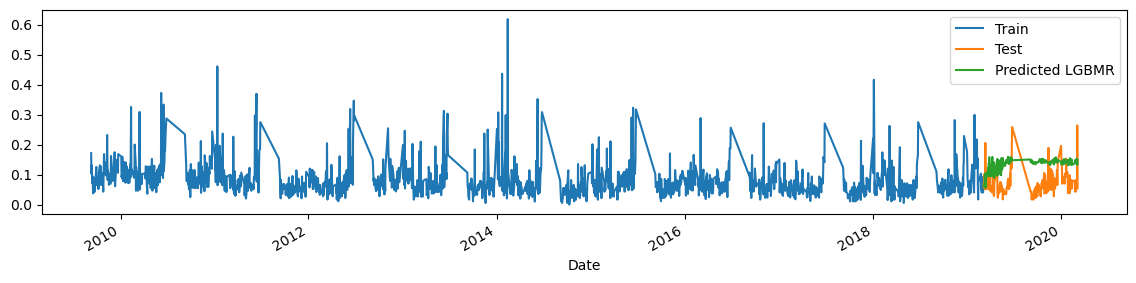

In [253]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end].plot(ax=ax, label = "Test")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label = "Predicted LGBMR")
ax.legend()

In [254]:
# TODO: Fix warnings!
# TODO: Incorporate into loop?
arima = pm.AutoARIMA(seasonal = True)
arima.fit(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end])

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end]))
arima_test = pd.DataFrame(arima_test, columns=['pred'])
arima_test = arima_test.set_index(dates_for_preds)

arima_rmse_train = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end], arima_train))
arima_rmse_test = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end], arima_test))
print('ARIMA RMSE Train:', arima_rmse_train,'\nARIMA RMSE Test:', arima_rmse_test)

C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

ARIMA RMSE Train: 0.05061004877462674 
ARIMA RMSE Test: 0.04074518357742449


C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [89]:
# Source on parameters for ARIMA
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

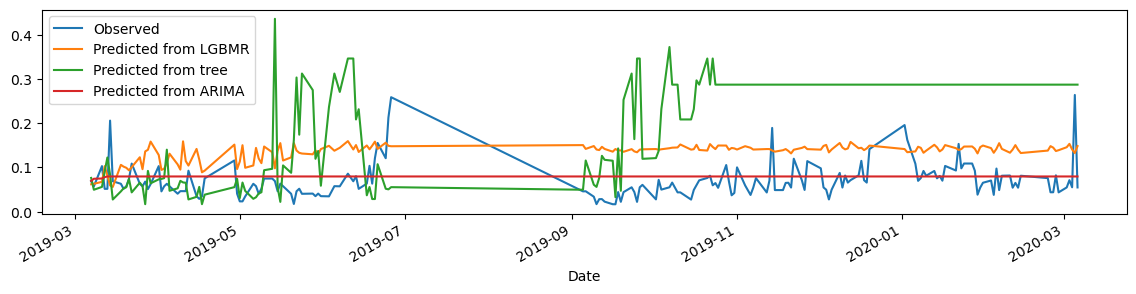

In [256]:
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
reg_model_preds['tree']['pred'].plot(ax=ax, label="Predicted from tree")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

In [257]:
# Hyperparameter tuning for most promising model: light gradient boosting machine regressor
# Code inspired by this source:
# https://skforecast.org/0.15.0/user_guides/hyperparameter-tuning-and-lags-selection.html
# Also see this source: https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 20]
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_1_school_for_ts['AbsenceRate'].loc[train_start:train_end]),
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster_lgbmr,
              y             = data_1_school_for_ts['AbsenceRate'].loc[train_start:test_end].reset_index(drop=True),
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error', # What we are trying to minimize
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.0017689823317217275


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 50}",0.001769,5,50
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 50}",0.001827,5,50
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 50}",0.001837,15,50
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 5, 'n_estimators': 100}",0.001911,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 15, 'n_estimators': 100}",0.001922,15,100
5,"[1, 2, 3, 20]",lags_3,"{'max_depth': 5, 'n_estimators': 50}",0.001933,5,50
6,"[1, 2, 3, 20]",lags_3,"{'max_depth': 5, 'n_estimators': 100}",0.001936,5,100
7,"[1, 2, 3]",lags_1,"{'max_depth': 15, 'n_estimators': 50}",0.001948,15,50
8,"[1, 2, 3]",lags_1,"{'max_depth': 5, 'n_estimators': 100}",0.001996,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'max_depth': 10, 'n_estimators': 50}",0.002014,10,50


In [258]:
# Get predictions from tuned LGBMR forecaster
# We can do this because above we had return_best = True
# That means that grid_search_forecaster updated our forecaster_lgbmr model
# to have the tuned (best) hyperparameters
# So when we run `forecaster_lgbmr.predict` below, we are getting predictions
# using the tuned LGBMR model
predicted_test_tuned_lgbmr = forecaster_lgbmr.predict(steps = len(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end]))
predicted_test_tuned_lgbmr = pd.DataFrame(predicted_test_tuned_lgbmr)
predicted_test_tuned_lgbmr['Date'] = dates_for_preds
predicted_test_tuned_lgbmr.set_index('Date', inplace = True)

# Get RMSE from tuned LGBMR forecaster
rmse_tuned_lgbmr = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end], predicted_test_tuned_lgbmr['pred']))

# Print RMSE, original and tuned
print(f"Light GRM regressor best root mean square error:  {rmse_tuned_lgbmr}")
print(f"Light GRM regressor untuned (original) root mean square error:  {reg_model_rmses['lgbmr']}")

Light GRM regressor best root mean square error:  0.06384729598807931
Light GRM regressor untuned (original) root mean square error:  0.07893585132004702


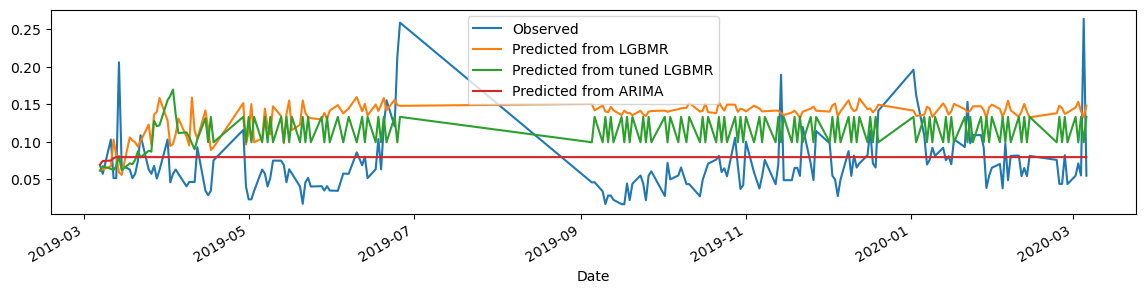

In [259]:
# Add data viz like the above but for "most likely" algorithms
# Point is (at least in part) to show that backfitting and hyperparameter tuning helped
fig, ax = plt.subplots(figsize=(14, 3))
data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
predicted_test_tuned_lgbmr['pred'].plot(ax=ax, label="Predicted from tuned LGBMR")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

The green line above showing the predicted values from the tuned LGBMR model shows a clear improvement over the original (untuned, default) LGBMR model. However, its predictions are still too high much of the time. The predictions from our auto-ARIMA model don't follow the peaks and valleys nearly as well, but do you think that model is doing better overall? Look back at the root mean squared error from the auto-ARIMA model to answer.

In [260]:
# Is there anything you'd like to do differently? What if you went through
# parameter tuning using a different metric?
# Run this cell and see in the help for grid_search_forecaster
# what options you have for metrics. Note that mean_squared_error
# penalizes larger errors because they are squared, and we have some
# time points where the acutal absence rates spike up and our models
# under predict. What if you tried mean_absolute_error instead?
help(grid_search_forecaster)

Help on function grid_search_forecaster in module skforecast.model_selection._search:

grid_search_forecaster(forecaster: 'object', y: 'pd.Series', cv: 'TimeSeriesFold | OneStepAheadFold', param_grid: 'dict', metric: 'str | Callable | list[str | Callable]', exog: 'pd.Series | pd.DataFrame | None' = None, lags_grid: 'list[int | list[int] | np.ndarray[int] | range[int]] | dict[str, list[int | list[int] | np.ndarray[int] | range[int]]] | None' = None, return_best: 'bool' = True, n_jobs: 'int | str' = 'auto', verbose: 'bool' = False, show_progress: 'bool' = True, output_file: 'str | None' = None) -> 'pd.DataFrame'
    Exhaustive search over specified parameter values for a Forecaster object.
    Validation is done using time series backtesting.

    Parameters
    ----------
    forecaster : ForecasterRecursive, ForecasterDirect
        Forecaster model.
    y : pandas Series
        Training time series.
    cv : TimeSeriesFold, OneStepAheadFold
        TimeSeriesFold or OneStepAheadFold 

In [ ]:
# This is the hyperparameter tuning copied and pasted from above with
# comments about what you could change
# Note the comment next to the metric so you can easily change that line
results = grid_search_forecaster( # Change `results` to a different name so you keep both sets of results
              forecaster    = forecaster_lgbmr,
              y             = data_1_school_for_ts['AbsenceRate'].loc[train_start:test_end].reset_index(drop=True),
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error', # Change 'mean_squared_error' to the metric you want to use
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
results # Don't forget to update the name `results` here to match what you changed it to above


In [ ]:
# Here is where you get your predictions based on your newly tuned model
# I've changed the names for you (added `_2`) so that you are not overwritin
# predictions from your first tuning

# Get predictions from RETUNED LGBMR forecaster
# We can do this because above we had return_best = True
# That means that grid_search_forecaster updated our forecaster_lgbmr model
# to have the RETUNED (best) hyperparameters
# So when we run `forecaster_lgbmr.predict` below, we are getting predictions
# using the RETUNED LGBMR model
predicted_test_tuned_lgbmr_2 = forecaster_lgbmr.predict(steps = len(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end]))
predicted_test_tuned_lgbmr_2 = pd.DataFrame(predicted_test_tuned_lgbmr_2)
predicted_test_tuned_lgbmr_2['Date'] = dates_for_preds
predicted_test_tuned_lgbmr_2.set_index('Date', inplace = True)

# Get RMSE from tuned LGBMR forecaster
# You could change this to get the metric you tuned for above by substituting
# metric's name where you see mean_squared_error and removing np.sqrt
# Example code for the right of the `=`, where you give it a better name
# than `metric_tuned_lgbmr_2` and replace `metric_you_used`: 
# metric_tuned_lgbmr_2 = metric_you_used(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end], predicted_test_tuned_lgbmr_2['pred'])
# Or if you just want to see how the RMSE looks with the redone tuning, keep
# this part as isof 
rmse_tuned_lgbmr_2 = np.sqrt(mean_squared_error(data_1_school_for_ts['AbsenceRate'].loc[test_start:test_end], predicted_test_tuned_lgbmr_2['pred']))

# Print RMSE, original and tuned
# Feel free to update to see the metric you used for tuning intead of the RMSE
# (rmse_tuned_lgbmr)
# Though note that you'd be comparing apples and oranges with the original
# the way the code is here, which keeps RMSE from the original
print(f"Light GRM regressor best root mean square error:  {rmse_tuned_lgbmr}")
print(f"Light GRM regressor untuned (original) root mean square error:  {reg_model_rmses['lgbmr']}")